In [1]:
#Load the Saved Model

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch.nn as nn
import torch.nn.functional as F

class CustomHeadClassifier(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout, num_classes):
        super(CustomHeadClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, attention_mask=None):
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(-1)
            x = (x * mask).sum(1) / mask.sum(1)
        else:
            x = x.mean(dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel

# For 650M:
base_model_name = "facebook/esm2_t33_650M_UR50D"
save_dir = "Saved_Models/LoRA_ESM2_650M_model_with_custom_head"

# 1) tokenizer (optional but recommended)
tokenizer = AutoTokenizer.from_pretrained(save_dir)

# 2) load the exact base model (must match training)
base_model = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=2)

# 3) attach your CustomHeadClassifier BEFORE loading the adapter,
#    because the adapter keys expect classifier.fc1 / fc2 to exist.
embedding_size = base_model.config.hidden_size
# Use the same hidden_size you used during training (e.g., 128)
base_model.classifier = CustomHeadClassifier(embedding_size, hidden_size=128, dropout=0.3, num_classes=2)

# 4) Now load the LoRA adapter into that model
#    This will map LoRA tensors into the base_model's modules (including classifier.fc1/fc2)
peft_model = PeftModel.from_pretrained(base_model, save_dir)

# 5) Load your saved custom head weights (you saved them separately)
custom_sd = torch.load(f"{save_dir}/custom_head.pt", map_location="cpu")
peft_model.model.classifier.load_state_dict(custom_sd)  # PeftModel wraps base in .model

# 6) move to device and eval or finetune
device = "cuda" if torch.cuda.is_available() else "cpu"
peft_model.to(device)
peft_model.eval()

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\default.DESKTOP-TP42RLP\anaconda3\Lib\site-packages\peft\config.py:165: UserWarning: Unexpected keyword arguments ['qalora_group_size', 'target_parameters', 'use_qalora'] for class LoraConfig, these are ignored. This probably means that you're loading a configuration file that was saved using a higher version of the library and additional parameters have been introduced since. It is highly recommended to upgrade the PEFT version before continuing (e.g. by running `pip install -U peft`).
  warnings.warn(


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): EsmForSequenceClassification(
      (esm): EsmModel(
        (embeddings): EsmEmbeddings(
          (word_embeddings): Embedding(33, 1280, padding_idx=1)
          (dropout): Dropout(p=0.0, inplace=False)
          (position_embeddings): Embedding(1026, 1280, padding_idx=1)
        )
        (encoder): EsmEncoder(
          (layer): ModuleList(
            (0-32): 33 x EsmLayer(
              (attention): EsmAttention(
                (self): EsmSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=1280, out_features=1280, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=1280, out_features=16, bias=False)
                    )
                    (lora_B): ModuleDict(
    

In [3]:
# Load the data
from Bio import SeqIO
import pandas as pd

local_fasta_path = 'TF_Ind_Labeled_Combined.txt'
sequences = []
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df_test = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df_test.head(5)

,name,sequence,label
0,A6NJG6,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...,1
1,Q96QS3,MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...,1
2,Q8N100,MKSCKPSGPPAGARVAPPCAGGTECAGTCAGAGRLESAARRRLAAN...,1
3,Q9NY43,MTMEGASGSSFGIDTILSSASSGSPGMMNGDFRPLGEARTADFRSQ...,1
4,Q96T88,MWIQVRTMDGRQTHTVDSLSRLTKVEELRRKIQELFHVEPGLQRLF...,1


In [4]:
from datasets import Dataset

df_test["label"] = df_test["label"].astype(int)
test_dataset = Dataset.from_pandas(df_test)

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, T5Tokenizer
tokenizer =AutoTokenizer.from_pretrained(base_model_name)
def tokenize_function(example):
    return tokenizer(example["sequence"], truncation=True, padding="max_length", max_length=1024)


In [6]:

tokenized_dataset = test_dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

In [7]:
from transformers import Trainer

trainer_test = Trainer(model=peft_model, tokenizer=tokenizer)

predictions = trainer_test.predict(test_dataset)

C:\Users\default.DESKTOP-TP42RLP\AppData\Local\Temp\ipykernel_20880\3737209683.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_test = Trainer(model=peft_model, tokenizer=tokenizer)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


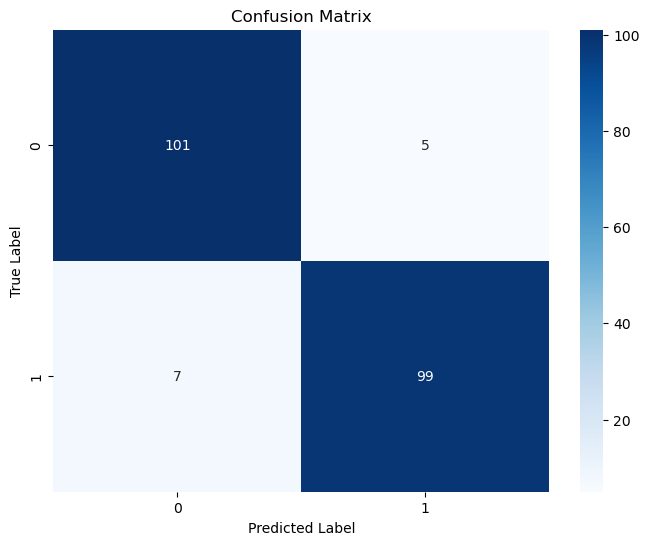

=== Metrics on Full Data ===
Accuracy: 0.9434
Precision: 0.9519
Specificity: 0.9528
Recall: 0.9340
MCC: 0.8870
F1: 0.9429
AUC: 0.9819

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       106
           1       0.95      0.93      0.94       106

    accuracy                           0.94       212
   macro avg       0.94      0.94      0.94       212
weighted avg       0.94      0.94      0.94       212


=== Bootstrapped Metrics (Mean ± Std) ===
Accuracy: 0.9435 ± 0.0162
Precision: 0.9526 ± 0.0213
Specificity: 0.9534 ± 0.0213
Recall: 0.9338 ± 0.0246
MCC: 0.8873 ± 0.0322
F1: 0.9429 ± 0.0167
AUC: 0.9820 ± 0.0079


In [8]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    classification_report,
)
from sklearn.utils import resample

# --- Extract predictions ---
logits = predictions.predictions
labels = predictions.label_ids
preds = np.argmax(logits, axis=-1)
probs = F.softmax(torch.tensor(logits), dim=-1).numpy()  # shape: [N, num_classes]

# --- Confusion Matrix ---
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --- Define function to compute metrics ---
def compute_metrics(labels, preds, probs):
    cm = confusion_matrix(labels, preds)
    TN, FP, FN, TP = cm.ravel()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    numerator = (TP * TN) - (FP * FN)
    denominator = np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    mcc = numerator / denominator if denominator > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, probs[:, 1]) if probs.shape[1] > 1 else np.nan

    return {
        "Accuracy": acc,
        "Precision": precision,
        "Specificity": specificity,
        "Recall": recall,
        "MCC": mcc,
        "F1": f1,
        "AUC": auc,
    }

# --- Compute metrics on full dataset ---
metrics = compute_metrics(labels, preds, probs)
print("=== Metrics on Full Data ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\nClassification Report:")
print(classification_report(labels, preds))

# --- Bootstrapping for Std Dev ---
n_bootstraps = 1000
rng = np.random.RandomState(42)
boot_metrics = {k: [] for k in metrics.keys()}

for i in range(n_bootstraps):
    indices = rng.randint(0, len(labels), len(labels))  # sample with replacement
    boot_labels = labels[indices]
    boot_preds = preds[indices]
    boot_probs = probs[indices]

    m = compute_metrics(boot_labels, boot_preds, boot_probs)
    for k in m:
        boot_metrics[k].append(m[k])

# --- Compute mean and std ---
print("\n=== Bootstrapped Metrics (Mean ± Std) ===")
for k in metrics.keys():
    mean_val = np.mean(boot_metrics[k])
    std_val = np.std(boot_metrics[k])
    print(f"{k}: {mean_val:.4f} ± {std_val:.4f}")